In [31]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, eig, svd
from numpy.random import uniform, randn, seed
from itertools import repeat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits

%matplotlib notebook
pd.options.display.float_format = '{:,.2f}'.format
seed(42)

In [32]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='talk', fscale=1.8, spines=False, 
             gridlines='--', ticks=True, grid=False, figsize=(7, 5))

In [33]:
def format3D(axis, labels=('x', 'y', 'z'), limits=None):
    """3D plot helper function to set labels, pane color, and axis limits"""
    axis.set_xlabel('\n${}$'.format(labels[0]), linespacing=3)
    axis.set_ylabel('\n${}$'.format(labels[1]), linespacing=3)
    axis.set_zlabel('\n${}$'.format(labels[2]), linespacing=3)
    transparent = (1.0, 1.0, 1.0, 0.0)
    axis.w_xaxis.set_pane_color(transparent)
    axis.w_yaxis.set_pane_color(transparent)
    axis.w_zaxis.set_pane_color(transparent)
    if limits:
        axis.set_xlim(limits[0])
        axis.set_ylim(limits[1])
        axis.set_zlim(limits[2])

### Creating a noisy 3D Ellipse

In [34]:
n_points, noise = 100, 0.1
angles = uniform(low=-np.pi, high=np.pi, size=n_points)
x = 2 * np.cos(angles) + noise * randn(n_points)
y = np.sin(angles) + noise * randn(n_points)

theta = np.pi/4 # 45 degree rotation
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                            [np.sin(theta), np.cos(theta)]])

rotated = np.column_stack((x, y)).dot(rotation_matrix)
x, y = rotated[:, 0], rotated[:, 1]

z = .2 * x  + .2 * y + noise * randn(n_points)
data = np.vstack((x, y, z)).T

### Plot the result 

<IPython.core.display.Javascript object>


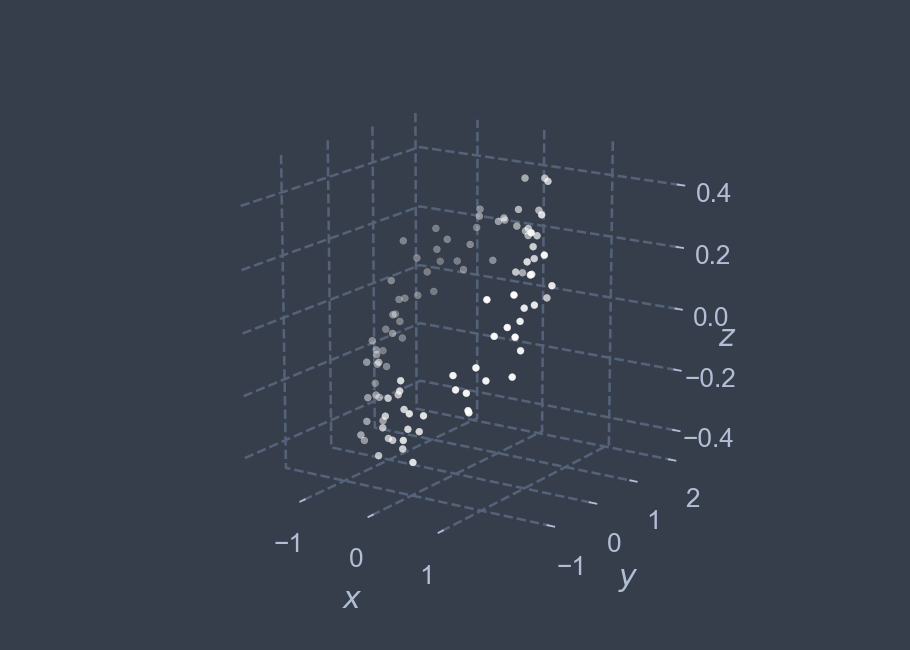

In [35]:
ax = plt.figure().gca(projection='3d')
ax.set_aspect('equal')
ax.scatter(x, y, z, c='white', s=25)
format3D(ax)
plt.tight_layout();

### Principal Components using scikit-learn

In [36]:
pca = PCA()
pca.fit(data)
C = pca.components_.T # columns = principal components
C

array([[ 0.71409739,  0.66929454,  0.20520656],
       [-0.70000234,  0.68597301,  0.1985894 ],
       [ 0.00785136,  0.28545725, -0.95835928]])

In [37]:
C[:, 0]

array([ 0.71409739, -0.70000234,  0.00785136])

In [38]:
explained_variance = pca.explained_variance_
explained_variance

array([1.92923132, 0.55811089, 0.00581353])

In [39]:
np.allclose(explained_variance/np.sum(explained_variance), 
            pca.explained_variance_ratio_)

True

### Principal Components from Covariance Matrix

- The covariance matrix is based on: $cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}$

In [40]:
cov = np.cov(data.T) # each row represents a feature
cov.shape

(3, 3)

#### Eigendecomposition: Eigenvectors & Eigenvalues 

- The Eigenvectors $w_i$ and Eigenvalues $\lambda_i$ for a square matrix $M$ are defined as follows:
$$M w_i = \lambda_i w_i$$

- This implies we can represent the matrix $M$ using Eigenvectors and Eigenvalues, where $W$ is a matrix that contains the Eigenvectors as column vectors, and $L$ is a matrix that contains the $\lambda_i$ as diagonal entries (and 0s otherwise):
$$M=WLW^{-1}$$

In [41]:
eigen_values, eigen_vectors = eig(cov)

#### eigenvectors = principal components 

In [42]:
eigen_vectors

array([[ 0.71409739, -0.66929454, -0.20520656],
       [-0.70000234, -0.68597301, -0.1985894 ],
       [ 0.00785136, -0.28545725,  0.95835928]])

In [43]:
np.allclose(np.abs(C), np.abs(eigen_vectors))

True

#### eigenvalues = explained variance 

In [44]:
eigen_values

array([1.92923132, 0.55811089, 0.00581353])

In [45]:
np.allclose(explained_variance, eigen_values)

True

#### Check that Eigendecomposition works

In [46]:
ev = np.zeros((3, 3))
np.fill_diagonal(ev, eigen_values)
ev # diagonal matrix

array([[1.92923132, 0.        , 0.        ],
       [0.        , 0.55811089, 0.        ],
       [0.        , 0.        , 0.00581353]])

In [47]:
decomposition = eigen_vectors.dot(ev).dot(inv(eigen_vectors))
np.allclose(cov, decomposition)

True

### Preferred: Singular Value Decomposition

#### Requires centering your data! 

In [48]:
n_features = data.shape[1]
data_ = data - data.mean(axis=0)

In [49]:
cov_manual = data_.T.dot(data_)/(len(data)-1)
np.allclose(cov_manual, cov)

True

In [50]:
U, s, Vt = svd(data_)
U.shape, s.shape, Vt.shape

((100, 100), (3,), (3, 3))

In [51]:
# Convert s from vector to diagonal matrix
S = np.zeros_like(data_)
S[:n_features, :n_features] = np.diag(s)
S.shape

(100, 3)

#### Show that the result indeed decomposes the original data

In [52]:
np.allclose(data_, U.dot(S).dot(Vt))

True

#### Confirm that $V^T$ contains the principal components 

In [53]:
np.allclose(np.abs(C), np.abs(Vt.T))

True

### Visualize 2D Projection 

In [54]:
pca = PCA(n_components=2)
data_2D = pca.fit_transform(data)

min_, max_ = data[:, :2].min(), data[:, :2].max()
xs, ys = np.meshgrid(np.linspace(min_,max_, n_points), 
                     np.linspace(min_,max_, n_points))

normal_vector = np.cross(pca.components_[0], pca.components_[1])
d = -pca.mean_.dot(normal_vector)
zs = (-normal_vector[0] * xs - normal_vector[1] * ys - d) * 1 / normal_vector[2]

In [55]:
C = pca.components_.T.copy()
proj_matrix = C.dot(inv(C.T.dot(C))).dot(C.T)
C[:,0] *= 2

<IPython.core.display.Javascript object>


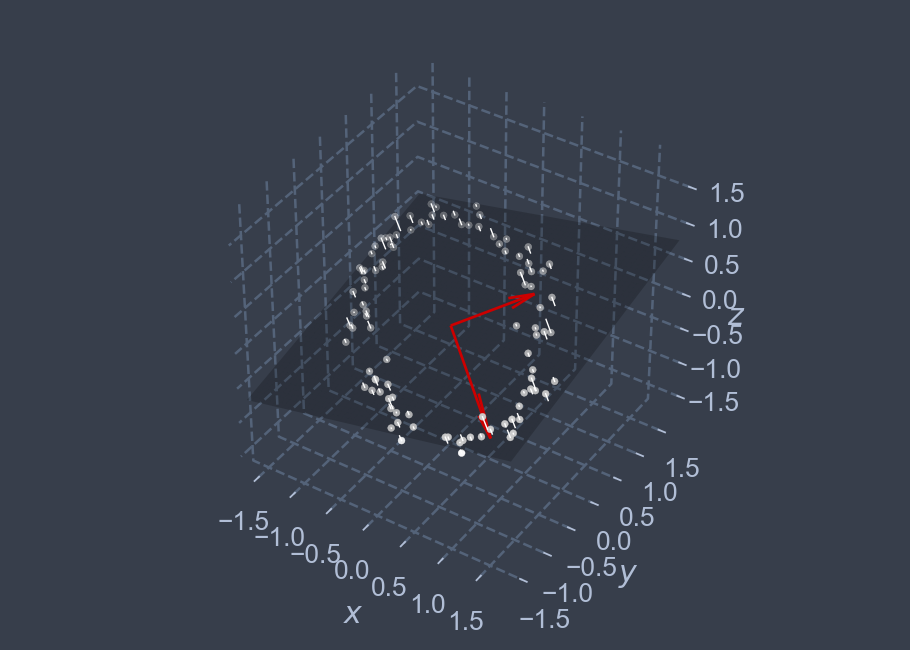

In [56]:
ax = plt.figure().gca(projection='3d')
ax.set_aspect('equal')

ax.plot_surface(xs, ys, zs, alpha=0.2, color='black',
                linewidth=1, antialiased=True)
ax.scatter(x, y, z, c='white', s=25)

for i in range(n_points):
    ax.plot(*zip(proj_matrix.dot(data[i]), data[i]), 
            color='white', lw=1)

origin = np.zeros((2, 3))
X, Y, Z, U, V, W = zip(*np.hstack((origin, C.T)))
ax.quiver(X, Y, Z, U, V, W, color='red')

format3D(ax, limits=list(repeat((min_, max_), 3)))
plt.tight_layout()

### 2D Representation

<IPython.core.display.Javascript object>


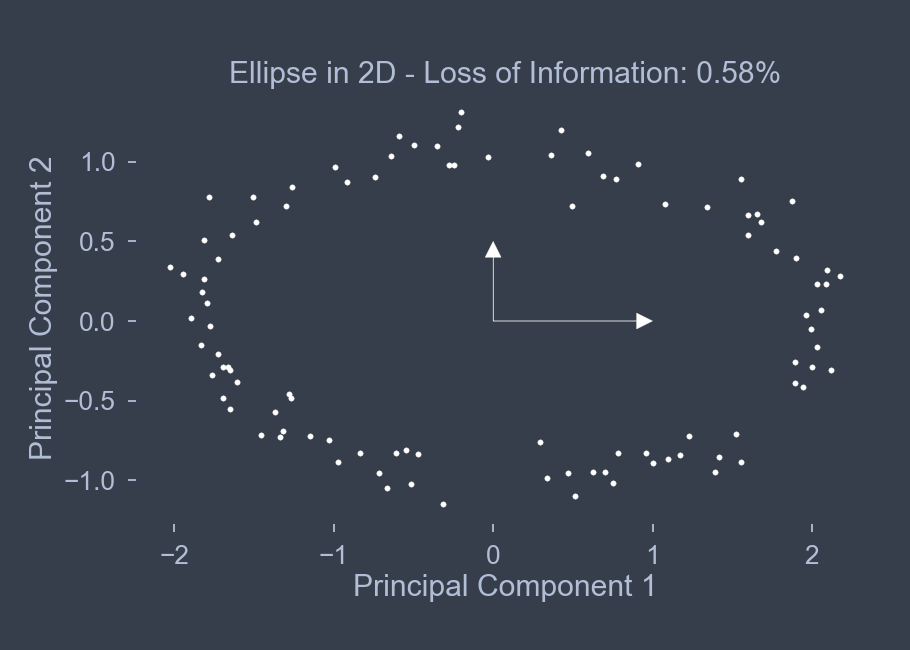

In [57]:
data_3D_inv = pca.inverse_transform(data_2D)
avg_error = np.mean(np.sum(np.square(data_3D_inv-data), axis=1))
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', 
     xlabel='Principal Component 1', 
     ylabel='Principal Component 2', 
     title='Ellipse in 2D - Loss of Information: {:.2%}'.format(avg_error))

ax.scatter(data_2D[:, 0], data_2D[:, 1], color='white', s=15)
ax.arrow(0, 0, 0, .5, head_width=0.1, length_includes_head=True, 
         head_length=0.1, fc='w', ec='w')
ax.arrow(0, 0, 1, 0, head_width=0.1, length_includes_head=True, 
         head_length=0.1, fc='w', ec='w')
fig.tight_layout();

### How many Components to represent 64 dimensions?

In [58]:
n_classes = 10
digits = load_digits(n_class=n_classes)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_samples, n_features

(1797, 64)

#### Evaluate the cumulative explained variance 

<IPython.core.display.Javascript object>


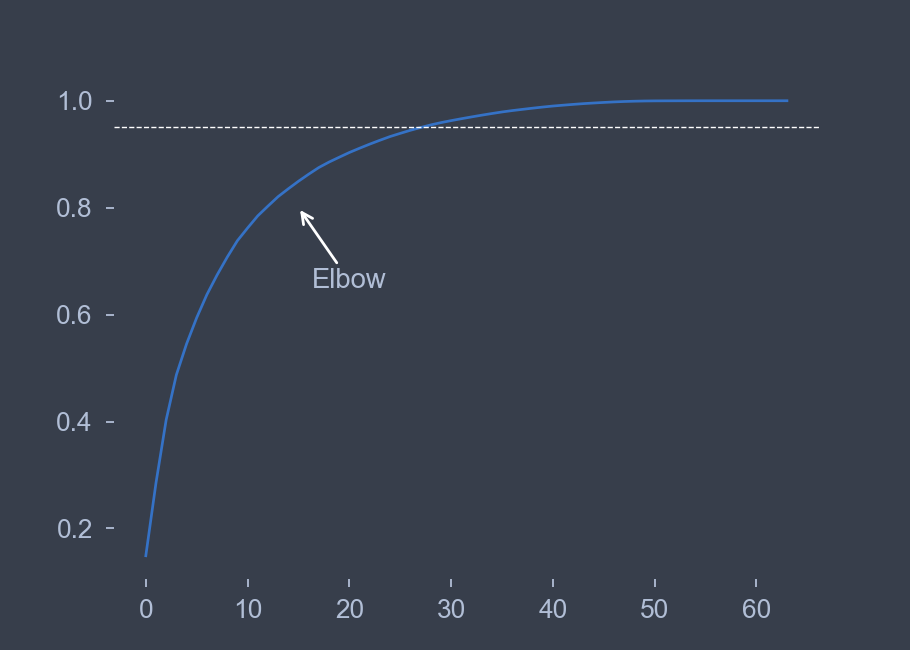

In [59]:
pca = PCA(n_components=64).fit(X)
plt.figure()
pd.Series(pca.explained_variance_ratio_).cumsum().plot()
plt.annotate('Elbow', xy=(15, .8), xycoords='data', xytext=(20, .65),
    textcoords='data', horizontalalignment='center',
    arrowprops=dict(color='w', lw=2, arrowstyle="->")
)
plt.axhline(.95, c='white', lw=1, ls='--');

### Automate generation of Components

In [60]:
pca = PCA(n_components=.95).fit(X)
pca.components_.shape

(29, 64)